# Kaggle Competition

## Auteurs : Oscar Pastural, Clément Florval, Louis Gauthier

---
## 0. Installation des dépendances nécessaires

In [118]:
%pip install transformers datasets scikit-learn evaluate pandas matplotlib seaborn torch torchvision torchaudio "transformers[torch]" "git+https://github.com/thomas-ferraz/fastText.git@0ffafb256d3f6325f8e5dbd527b4e22c1a7e49d2"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/thomas-ferraz/fastText.git (to revision 0ffafb256d3f6325f8e5dbd527b4e22c1a7e49d2) to /private/var/folders/_8/vpwl6kq551v_bt6m3llx5n9c0000gn/T/pip-req-build-ue3v0sro
  Running command git clone --filter=blob:none --quiet https://github.com/thomas-ferraz/fastText.git /private/var/folders/_8/vpwl6kq551v_bt6m3llx5n9c0000gn/T/pip-req-build-ue3v0sro
  Running command git rev-parse -q --verify 'sha^0ffafb256d3f6325f8e5dbd527b4e22c1a7e49d2'
  Running command git fetch -q https://github.com/thomas-ferraz/fastText.git 0ffafb256d3f6325f8e5dbd527b4e22c1a7e49d2
  Running command git checkout -q 0ffafb256d3f6325f8e5dbd527b4e22c1a7e49d2
  Resolved https://github.com/thomas-ferraz/fastText.git to commit 0ffafb256d3f6325f8e5dbd527b4e22c1a7e49d2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install -

## 0.5 Import des librairies

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import evaluate
import torch
import os

/Users/louisgauthier/Documents/CentraleSupelec/NLP/anlp-kaggle/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set the device to be used
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
print(f"Using device: {device}")

# If cache directory doesn't exist, create it
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)

Using device: mps


## 1. Import et EDA

In [3]:
train_df = pd.read_csv("data/train_submission.csv")
test_df = pd.read_csv("data/test_without_labels.csv")

In [4]:
# Afficher les 5 premières lignes du jeu de données d'entraînement
print("Aperçu du jeu de données d'entraînement :")
display(train_df.head())

# Afficher la taille (nombre de lignes et colonnes) des datasets train et test
print(f"Dimensions du dataset train : {train_df.shape}")
print(f"Dimensions du dataset test : {test_df.shape}")

Aperçu du jeu de données d'entraînement :


,Usage,Text,Label
0,Public,َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...,hau
1,Public,Filmen forteller historien om Will Hunting en...,nob
2,Public,An Arthrostylidium berryi in uska species han ...,wln
3,Public,Kancunarí enemigosniyquichejta munacuychej al...,quh
4,Public,Warmeqa ama yachachichunchu hermanospa tantaku...,quh


Dimensions du dataset train : (190599, 3)
Dimensions du dataset test : (190567, 2)


### Informations générales et valeurs manquantes

In [5]:
# Afficher des informations générales sur le dataset (types, non-null, etc.)
print("Infos sur le dataset train :")
train_df.info()

# Vérifier la présence de valeurs manquantes dans le dataset train
print("\nNombre de valeurs manquantes par colonne dans le dataset train :")
print(train_df.isnull().sum())

# Vérifier la présence de valeurs manquantes dans le dataset test
print("\nNombre de valeurs manquantes par colonne dans le dataset test :")
print(test_df.isnull().sum())

Infos sur le dataset train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190599 entries, 0 to 190598
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Usage   190599 non-null  object
 1   Text    190599 non-null  object
 2   Label   190099 non-null  object
dtypes: object(3)
memory usage: 4.4+ MB

Nombre de valeurs manquantes par colonne dans le dataset train :
Usage      0
Text       0
Label    500
dtype: int64

Nombre de valeurs manquantes par colonne dans le dataset test :
Usage    0
Text     0
dtype: int64


In [6]:

# Valeurs uniques de la colonne "Label" dans le dataset train
lang_values = train_df["Label"].unique()
print("\nValeurs uniques de la colonne 'Label' dans le dataset train :")
print(lang_values)

# Nombre de langues différentes dans le dataset train
print("\nNombre de langues différentes dans le dataset train :")
print(len(lang_values))



Valeurs uniques de la colonne 'Label' dans le dataset train :
['hau' 'nob' 'wln' 'quh' 'scn' 'uzb' 'roh' 'ayr' 'rmy' 'guj' 'zho' 'nso'
 'ote' 'vep' 'hat' 'lin' 'hin' 'ltz' 'kur' 'fij' 'pag' 'udm' 'kpg' 'ori'
 'aze' 'che' 'lhu' 'seh' 'npi' 'ctu' 'szl' 'dan' 'kmr' 'lua' 'cos' 'pes'
 'kan' 'nav' 'som' 'poh' 'bik' 'hbs' 'kbd' 'aln' 'ron' 'tso' 'chk' 'amh'
 'lao' 'qvi' 'pfl' 'sun' 'deu' 'crh' 'azb' 'nap' 'swa' 'min' 'grc' 'aym'
 'aka' 'mar' 'acm' 'orm' 'ksh' 'epo' 'nds' 'ven' 'kaz' 'tgk' 'quw' 'ixl'
 'abk' 'kek' 'que' 'tsn' 'tah' 'srd' 'sag' 'kon' 'tca' 'arz' 'cbk' 'khm'
 'bak' 'ngu' nan 'bre' 'tgl' 'kmb' 'bih' 'ndo' 'rop' 'swe' 'gsw' 'luo'
 'tha' 'iku' 'suz' 'sah' 'run' 'pol' 'ces' 'hye' 'knv' 'glg' 'yom' 'nya'
 'bcl' 'quc' 'oss' 'sin' 'gug' 'lat' 'swh' 'mlg' 'mco' 'mhr' 'vec' 'tir'
 'kac' 'hun' 'tum' 'jbo' 'bjn' 'pap' 'kaa' 'xho' 'pms' 'hne' 'nno' 'mzh'
 'vol' 'kir' 'pus' 'ksd' 'top' 'bem' 'diq' 'zlm' 'jam' 'gla' 'toj' 'twi'
 'pcd' 'yor' 'tlh' 'hsb' 'tpi' 'krc' 'quy' 'srn' 'fao' 'lus' 'm

### Distribution des labels (langues)

Distribution des langues dans le dataset d'entraînement :
Label
tgk    1500
kur    1000
hin    1000
aze    1000
bak    1000
       ... 
tvl       2
toi       1
kua       1
gcr       1
gaa       1
Name: count, Length: 389, dtype: int64


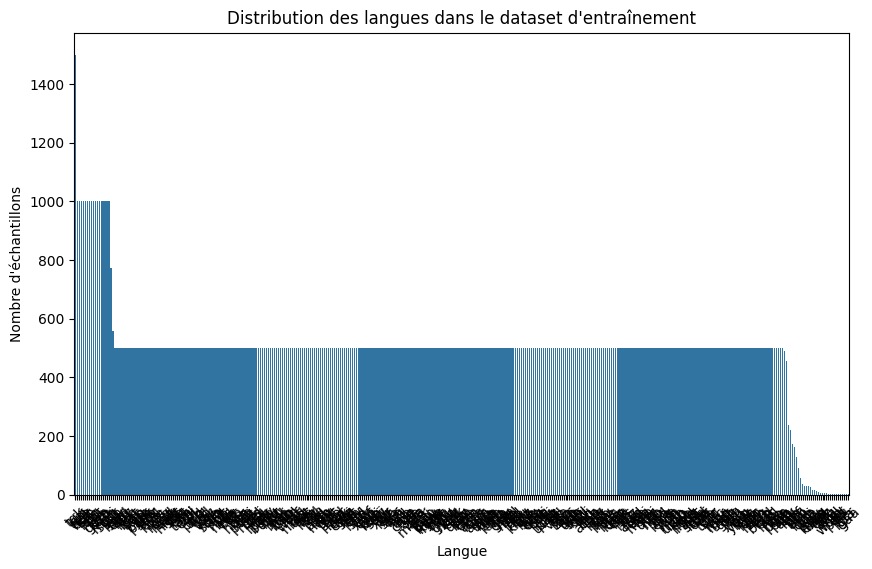

In [7]:
# Compter le nombre d'occurrences de chaque langue dans le dataset d'entraînement
print("Distribution des langues dans le dataset d'entraînement :")
langues = train_df["Label"].value_counts()
print(langues)

# Visualiser la distribution à l'aide d'un graphique
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data=train_df, x="Label", order=langues.index)
plt.title("Distribution des langues dans le dataset d'entraînement")
plt.xlabel("Langue")
plt.ylabel("Nombre d'échantillons")
plt.xticks(rotation=45)
plt.show()

### Analyse de la longueur des textes

Statistiques sur la longueur des textes :
count    190599.000000
mean        149.974339
std         376.791972
min           5.000000
25%          64.000000
50%         104.000000
75%         172.000000
max       78939.000000
Name: text_length, dtype: float64


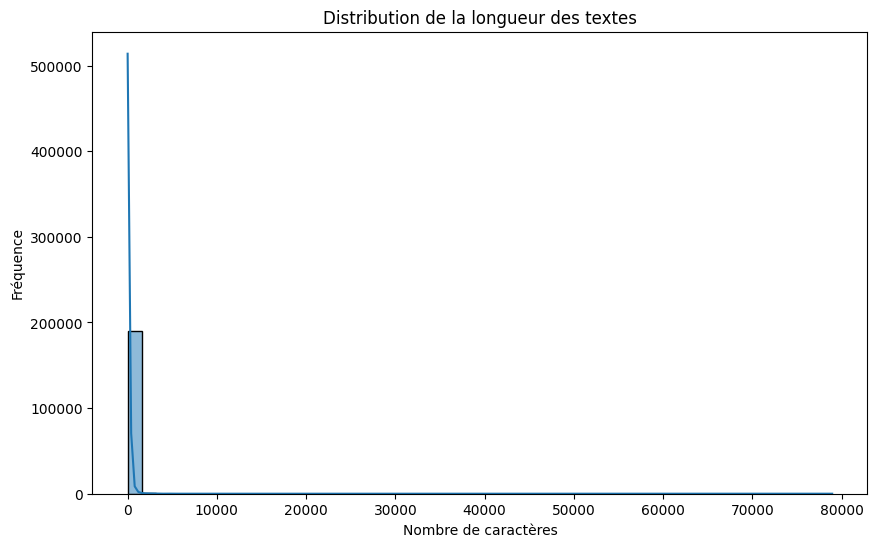

In [8]:
# Calculer la longueur de chaque texte dans le dataset d'entraînement
train_df["text_length"] = train_df["Text"].apply(len)

# Afficher quelques statistiques sur la longueur des textes
print("Statistiques sur la longueur des textes :")
print(train_df["text_length"].describe())

# Visualiser la distribution de la longueur des textes
plt.figure(figsize=(10,6))
sns.histplot(train_df["text_length"], bins=50, kde=True)
plt.title("Distribution de la longueur des textes")
plt.xlabel("Nombre de caractères")
plt.ylabel("Fréquence")
plt.show()

### Exemples de textes par langue

In [9]:
# Afficher quelques exemples de textes pour chaque langue afin de vérifier la qualité des données
grouped = train_df.groupby("Label")

# Garder seulement 10 langues aléatoires
grouped = grouped.filter(lambda x: x["Label"].iloc[0] in lang_values[:10]).groupby("Label")

for label, groupe in grouped:
    print(f"\nExemples pour la langue '{label}' :")
    display(groupe["Text"].head(3))


Exemples pour la langue 'ayr' :


8       Pä waranq pä tunka-2020 maratakisti niyaw khaw...
686     ADD ukan wawanakax janiw masinakapamp walt'aya...
1022    Khititix mä ch'axwaskir markar tumpir sarañ mu...
Name: Text, dtype: object


Exemples pour la langue 'guj' :


10     જ્યાં સુધી કોઈ પોસ્ટ પોસ્ટ ખાસ કરીને કહે છે કે...
350    સ્‍કુલ જીવનમાં બાહય પરિસ્‍થિતિઓનો પ્રભાવ પણ એમ...
703    जघानशरणं तस्यात्सर्वशत्रुहरं परम्| ध्यात्वा पं...
Name: Text, dtype: object


Exemples pour la langue 'hau' :


0      َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...
254    Game da shigar kasar Sin kasuwar hada-hadar ku...
689           سپوږمۍ او ستورو تر اسمانه سترګې پټې نه کړي
Name: Text, dtype: object


Exemples pour la langue 'nob' :


1       Filmen forteller historien om Will Hunting  en...
159       Hvis selskapet har omsetning utenfor mva-loven.
1613    Støtter alle iPhone-modeller som kjører på iOS...
Name: Text, dtype: object


Exemples pour la langue 'quh' :


3      Kancunarí enemigosniyquichejta munacuychej  al...
4      Warmeqa ama yachachichunchu hermanospa tantaku...
185    Chaypeqa wawaspis manaraj imapi mana wañonqank...
Name: Text, dtype: object


Exemples pour la langue 'rmy' :


9               kolen liparyem angle  soske ol pherena e
583    O Vasile Yonesko si ekh Rom andar e Rumuniya  ...
719    Zaro si Kenoriya (Partikloriya) so nay dikhe t...
Name: Text, dtype: object


Exemples pour la langue 'roh' :


7      Davant dal tut sesa il primviolinist ch’ha mag...
14     Art. 267a P. Restituziun da la chaussa / II. E...
856    En blers pajais da l’Europa vegni pajà cun eur...
Name: Text, dtype: object


Exemples pour la langue 'scn' :


5       Nta l'anfibbi anuri  accumpari l'aricchia medi...
1355    L’attivitati principali dû paisi era l’agricul...
1778    Sta canzuni  nzemi a Radio Ga Ga sunnu alcuni ...
Name: Text, dtype: object


Exemples pour la langue 'uzb' :


6      d ) xalqaro iqtisodiy hamkorlikni kengaytirish...
577    Human Rights Watch Turkmanistonga 1999 yildan ...
588    Биринчидан  ҳозирги болалар тезфаҳм. Ўйлайманк...
Name: Text, dtype: object


Exemples pour la langue 'wln' :


2      An Arthrostylidium berryi in uska species han ...
237    Polyodontes tidemani in uska species han Annel...
333    An Onobrychis tavernieraefolia in uska species...
Name: Text, dtype: object

## 2. Préparation du Dataset

In [10]:
# Nettoyage et conversion des colonnes de texte
train_df["Text"] = train_df["Text"].fillna("").astype(str)
test_df["Text"] = test_df["Text"].fillna("").astype(str)

In [11]:
# Encodage des labels
le = LabelEncoder()
train_df["Label"] = le.fit_transform(train_df["Label"])

In [12]:
# Conversion en Dataset Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Renommage de la colonne "Label" en "labels" pour l'entraînement
train_dataset = train_dataset.rename_column("Label", "labels")

In [13]:
# Tokenisation avec un modèle
model_checkpoint = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [14]:
def tokenize_function(example):
    return tokenizer(example["Text"], padding="max_length", truncation=True)

## 3. Division train, test, validation datasets

In [15]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 190567/190567 [00:16<00:00, 11263.31 examples/s]


In [16]:
# Séparation en ensemble d'entraînement et d'évaluation
split_dataset = train_dataset.train_test_split(test_size=0.1, seed=42)
train_split = split_dataset["train"]
eval_split = split_dataset["test"]

### Construction du vocabulaire de caractères par langue

In [17]:
import re
from collections import defaultdict

def extract_ngrams(text, n=1):
    """
    Extract a set of n-grams of length n from the text.
    Non-alphanumeric characters are removed before processing.
    
    Args:
        text (str): Input text.
        n (int): Length of the n-grams to extract.
    
    Returns:
        set: A set of n-grams extracted from the cleaned text.
    """
    # Remove non-alphanumeric characters (using re.sub which is very fast)
    filtered_text = re.sub(r'\W+', '', text, flags=re.UNICODE)
    # If the cleaned text is shorter than n, return an empty set
    if len(filtered_text) < n:
        return set()
    # Use set comprehension for fast extraction of all n-grams
    return {filtered_text[i:i+n] for i in range(len(filtered_text) - n + 1)}

from collections import defaultdict

def build_language_ngram_vocab(train_df, le, n):
    """
    Build an n-gram vocabulary for each language.
    
    Returns:
      dict: A mapping from language name to a set of n-grams.
    """
    vocab = defaultdict(set)
    for lang_code, group in train_df.groupby("labels"):
        lang_name = le.inverse_transform([lang_code])[0]
        texts = group["Text"].tolist()
        for text in texts:
            cleaned_text = re.sub(r'\W+', '', text, flags=re.UNICODE)
            if len(cleaned_text) >= n:
                ngrams = {cleaned_text[i:i+n] for i in range(len(cleaned_text) - n + 1)}
            else:
                ngrams = set()
            vocab[lang_name].update(ngrams)
    return vocab

split_df = train_split.to_pandas()

# Build global n-gram vocabularies for n=1 and n=2 (for unigrams and bigrams)
lang_ngram_vocab = {
    1: build_language_ngram_vocab(split_df, le, n=1),
    2: build_language_ngram_vocab(split_df, le, n=2),
    3: build_language_ngram_vocab(split_df, le, n=3),
    4: build_language_ngram_vocab(split_df, le, n=4),
}

In [18]:
import re
import time
import numpy as np

# Global variables to track n-gram matching fractions and call count.
global_filter_calls = 0
global_ngram_fractions = {}  # keys: n (int), value: list of fractions

def filter_language_for_text(text, language, thresholds, timing_debug=False, is_true_label=False):
    """
    Check that for each n in 1..max_n (max_n = len(thresholds)):
      The fraction of n-grams in the text that are present in the language's n-gram vocabulary 
      is >= the corresponding threshold.
    
    Parameters:
      text (str): The text to filter.
      language (str): The language to check against.
      thresholds (tuple or list): A sequence of threshold values, one for each n-gram length (from 1 to max_n).
      timing_debug (bool): If True, prints timing and debugging information for each step.
      is_true_label (bool): When True, record the fraction values (for the true label) to track distribution.
    
    Returns:
      bool: True if for all n the matching fraction is >= threshold; otherwise False.
    """
    global global_filter_calls, global_ngram_fractions
    total_start = time.perf_counter()
    
    # Clean the text once to remove non-alphanumeric characters.
    cleaned_text = re.sub(r'\W+', '', text, flags=re.UNICODE)
    if timing_debug:
        print(f"Text cleaning took {time.perf_counter() - total_start:.6f} seconds.")
    
    # Loop over n-gram lengths from 1 to max_n
    for n, threshold in enumerate(thresholds, start=1):
        if threshold is None:
            continue
        
        start = time.perf_counter()
        if len(cleaned_text) < n:
            ngrams = set()
        else:
            # Efficiently build n-grams using a set comprehension.
            ngrams = {cleaned_text[i:i+n] for i in range(len(cleaned_text) - n + 1)}
        t_extract = time.perf_counter() - start
        if timing_debug:
            print(f"{n}-gram extraction took {t_extract:.6f} seconds (found {len(ngrams)} n-grams).")
        
        start = time.perf_counter()
        # Get the pre-built vocabulary for n-grams of length n for this language.
        lang_ngrams = lang_ngram_vocab.get(n, {}).get(language, set())
        if not ngrams or not lang_ngrams:
            fraction = 0.0
        else:
            match_count = sum(1 for gram in ngrams if gram in lang_ngrams)
            fraction = match_count / len(ngrams)
        t_match = time.perf_counter() - start
        if timing_debug:
            print(f"{n}-gram matching took {t_match:.6f} seconds (fraction: {fraction:.4f}).")
        
        # If this is a true label call, record the fraction for statistical tracking.
        if is_true_label:
            if n not in global_ngram_fractions:
                global_ngram_fractions[n] = []
            global_ngram_fractions[n].append(fraction)
            
            # Increase the call counter only on true label calls.
            global_filter_calls += 1
            
            # Every 1,000 calls, compute and print the 1st percentile (lowest 1%) for each n-gram size.
            if global_filter_calls % 4000 == 0:
                print(f"\nAfter {global_filter_calls} true label calls, 1% percentiles:")
                for key in sorted(global_ngram_fractions.keys()):
                    perc = np.percentile(global_ngram_fractions[key], 1)
                    print(f"  {key}-gram: {perc:.4f}")
        
        # If the fraction is below the required threshold for this n, return False immediately.
        if fraction < threshold:
            if timing_debug:
                print(f"Threshold for {n}-grams not met: {fraction:.4f} < {threshold}")
            return False
    
    total_time = time.perf_counter() - total_start
    if timing_debug:
        print(f"Total filtering time: {total_time:.6f} seconds.")
    
    return True

In [19]:
# Chargement du modèle pour la classification
num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Training et Résultats

In [20]:
# Définition des arguments d'entraînement
training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none"  # Désactive le reporting vers wandb, problème généré sur Colab
)

/Users/louisgauthier/Documents/CentraleSupelec/NLP/anlp-kaggle/.venv/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
# Définition de la métrique d'évaluation
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [22]:
# Création du Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_split,
    eval_dataset=eval_split,
    compute_metrics=compute_metrics,
)

In [ ]:
# Entraînement du modèle. Si vous avez déjà entraîné le modèle, vous pouvez passer cette étape et charger le modèle entraîné directement.
trainer.train()
trainer.save_model("modele_5_epochs")

In [23]:
# Charger le modèle entraîné
model = AutoModelForSequenceClassification.from_pretrained("./modele_5_epochs").to(device)


In [24]:
import os
import torch
from tqdm.auto import tqdm
import numpy as np
import torch.nn.functional as F
import csv

# Création d'un répertoire pour sauvegarder les prédictions (à ajouter dans .gitignore)
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

def predict_and_save(dataloader, filename):
    """
    Effectue les prédictions avec affichage de la progression, calcule les probabilités,
    et sauvegarde les prédictions (étiquette et probabilités pour chaque classe) dans un CSV.
    """
    predictions_list = []
    probabilities_list = []
    
    model.eval()
    for batch in tqdm(dataloader, desc=f"Prédiction sur {filename}"):
        # Déplacement des tenseurs sur le device du modèle
        batch = {k: v.to(model.device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            # Calcul des probabilités via softmax
            probs = F.softmax(logits, dim=-1).detach().cpu().numpy()
            batch_preds = np.argmax(probs, axis=-1)
            
            predictions_list.append(batch_preds)
            probabilities_list.append(probs)
    
    # Concaténation des résultats de tous les batches
    preds = np.concatenate(predictions_list, axis=0)
    preds_probs = np.concatenate(probabilities_list, axis=0)
    preds_labels = le.inverse_transform(preds)
    
    # Sauvegarde dans un fichier CSV
    output_path = os.path.join(output_dir, filename)
    with open(output_path, "w", encoding="utf-8", newline='') as f:
        writer = csv.writer(f)
        # Entête : ID, étiquette prédite, puis une colonne par classe pour les probabilités
        header = ["ID", "Predicted Label"] + [f"Prob_Class_{i}" for i in range(preds_probs.shape[1])]
        writer.writerow(header)
        for idx, (label, probs) in enumerate(zip(preds_labels, preds_probs)):
            row = [idx + 1, label] + list(probs)
            writer.writerow(row)
    
    print(f"Prédictions sauvegardées dans {output_path}")
    
    return preds, preds_probs, preds_labels

# Obtention du DataLoader pour le jeu de test
test_dataloader = trainer.get_test_dataloader(test_dataset)
# Obtention du DataLoader pour le jeu d'évaluation
eval_dataloader = trainer.get_eval_dataloader(eval_split)

# Prédictions sur le jeu d'évaluation
eval_preds, eval_preds_probs, eval_preds_labels = predict_and_save(eval_dataloader, "pred_labels_eval.csv")

# Prédictions sur le jeu de test (données non étiquetées)
# test_preds, test_preds_probs, test_preds_labels = predict_and_save(test_dataloader, "pred_labels_test.csv")


Prédiction sur pred_labels_eval.csv: 100%|██████████| 1192/1192 [02:42<00:00,  7.33it/s]


Prédictions sauvegardées dans predictions/pred_labels_eval.csv


In [25]:
from tqdm.auto import tqdm
import numpy as np

def apply_filter_to_predictions(preds_probs, dataset, thresholds):
    """
    Apply the n-gram based filter to the predictions using a generic thresholds tuple.
    
    For each sample and each candidate language, the filter checks that for each n in 1..N:
      - The fraction of n-grams in the text that are present in the language's n-gram vocabulary 
        is >= the corresponding threshold (provided in 'thresholds').
    If a candidate does not meet these criteria, its probability is set to 0.
    
    Args:
        preds_probs (np.array): Array of probabilities for each sample (shape: [n_samples, n_languages]).
        dataset: HuggingFace dataset containing the original "Text" column and possibly "labels".
        thresholds (tuple or list): A sequence of threshold values for n-grams of lengths 1 to N.
    
    Returns:
        tuple: (filtered_preds, filtered_preds_labels)
            - filtered_preds: Array of indices for the selected classes after filtering.
            - filtered_preds_labels: List of corresponding language names.
    """
    filtered_preds = []
    filtered_preds_labels = []
    
    n_true_filtered = 0    # Number of samples for which the true label was filtered out
    total_classes_kept = 0 # Total number of non-zero probabilities kept per sample
    total_samples = len(preds_probs)
    num_classes = preds_probs.shape[1]
    
    # Check if the dataset has true labels
    has_true_labels = "labels" in dataset.column_names if hasattr(dataset, "column_names") else False
    
    # Loop over each sample with a progress bar
    for i, probs in tqdm(enumerate(preds_probs), total=total_samples, desc="Filtering predictions"):
        text = dataset[i]["Text"]
        # Copy probabilities for modification
        filtered_probs = probs.copy()
        
        # For each candidate language, filter out if it doesn't meet the n-gram thresholds.
        for j, lang in enumerate(le.classes_):
            if not filter_language_for_text(text, lang, thresholds=thresholds, timing_debug=False):
                filtered_probs[j] = 0.0
        
        # Count how many classes are kept (non-zero probabilities)
        classes_kept = np.count_nonzero(filtered_probs)
        total_classes_kept += classes_kept
        
        # If true labels are available, check whether the true label was filtered out.
        if has_true_labels:
            true_label_idx = dataset[i]["labels"]
            true_lang = le.inverse_transform([true_label_idx])[0]
            if not filter_language_for_text(text, true_lang, thresholds=thresholds, is_true_label=False):
                n_true_filtered += 1
        
        # If all probabilities were filtered out, fallback to the original prediction.
        if np.sum(filtered_probs) == 0:
            filtered_pred = np.argmax(probs)
        else:
            filtered_pred = np.argmax(filtered_probs)
        
        filtered_preds.append(filtered_pred)
        filtered_preds_labels.append(le.inverse_transform([filtered_pred])[0])
    
    # Display statistics if true labels are available
    if has_true_labels:
        rate_true_filtered = n_true_filtered / total_samples
        print(f"For thresholds {thresholds}, {n_true_filtered}/{total_samples} samples ({rate_true_filtered*100:.2f}%) had their true label filtered out.")
    
    avg_classes_kept = total_classes_kept / total_samples
    rate_classes_kept = avg_classes_kept / num_classes
    print(f"Average number of classes kept: {avg_classes_kept:.2f} out of {num_classes} ({rate_classes_kept*100:.2f}%).")
    
    return np.array(filtered_preds), filtered_preds_labels

# Example usage:
# Apply the filter on the evaluation set using a thresholds tuple for n=1 and n=2.
filtered_eval_preds, filtered_eval_preds_labels = apply_filter_to_predictions(
    # eval_preds_probs, eval_split, thresholds=(0.931, 0.54, 0.3, 0.17) # 0.8762
    eval_preds_probs, eval_split, thresholds=(None, None, 0.3) # 0.8785
)

# After 72000 true label calls, 1% percentiles:
#   1-gram: 0.9315
#   2-gram: 0.5402
#   3-gram: 0.3028
#   4-gram: 0.1712

# Display a few examples for verification.
print("Examples of filtered predictions on the evaluation set:")
for i in range(5):
    sample_text = eval_split[i]["Text"]
    print(f"Text (start): {sample_text[:50]}...  - Filtered prediction: {filtered_eval_preds_labels[i]}")

Filtering predictions: 100%|██████████| 19060/19060 [03:38<00:00, 87.06it/s] 

For thresholds (None, None, 0.3), 344/19060 samples (1.80%) had their true label filtered out.
Average number of classes kept: 185.28 out of 390 (47.51%).
Examples of filtered predictions on the evaluation set:
Text (start): भूंयरचणुकेचे नदरेन युरोप खंडाचे मुखेलपणान चार वांट...  - Filtered prediction: gom
Text (start): Fazer o auto exame de mama é muito importante....  - Filtered prediction: por
Text (start): Diawu diana dieto didi dikuikama mu beno bila tuze...  - Filtered prediction: yom
Text (start): Kanị Fẹstọsị chọ n'o mẹyeni ndị Ju  ya ọ nọ jụma P...  - Filtered prediction: ikk
Text (start): Jeg spiste hvad end der så godt ud....  - Filtered prediction: dan


In [26]:
# Évaluation de la performance sur le jeu d'évaluation

# Récupération des labels réels du dataset d'évaluation
true_labels = np.array(eval_split["labels"])

# Calcul de l'accuracy sur le jeu d'évaluation
eval_accuracy = accuracy_metric.compute(predictions=eval_preds, references=true_labels)["accuracy"]
print(f"Accuracy sur le jeu d'évaluation : {eval_accuracy:.4f}")

filtered_eval_accuracy = accuracy_metric.compute(predictions=filtered_eval_preds, references=true_labels)["accuracy"]
print(f"Accuracy sur le jeu d'évaluation (filtrage) : {filtered_eval_accuracy:.4f}")

Accuracy sur le jeu d'évaluation : 0.8693
Accuracy sur le jeu d'évaluation (filtrage) : 0.8785


In [27]:
import random

# Préparer un dictionnaire regroupant, pour chaque langue, la liste des textes du jeu d'entraînement
train_by_label = {}
for lang in le.classes_:
    # Convertir le label en sa forme encodée
    encoded = le.transform([lang])[0]
    # Récupérer la liste des textes dont le label correspond
    train_by_label[lang] = train_df[train_df["Label"] == encoded]["Text"].tolist()

print("Exemples d'échantillons mal étiquetés avec comparaison d'exemple de texte pour le label prédit:")

mislabeled_examples = []

count = 0
# Parcourir les échantillons du jeu d'évaluation
for i in range(len(eval_split)):
    # Récupérer le label attendu (vrai label) et le label prédit (après filtrage)
    true_label = le.inverse_transform([eval_split[i]["labels"]])[0]
    predicted_label = filtered_eval_preds_labels[i]
    
    # Si la prédiction est différente du vrai label, afficher l'exemple
    if true_label != predicted_label:
        input_text = eval_split[i]["Text"]
        # Obtenir un exemple aléatoire du jeu d'entraînement pour le label prédit
        candidate_texts = train_by_label.get(predicted_label, [])
        random_example = random.choice(candidate_texts) if candidate_texts else "Aucun exemple disponible."
        
        mislabeled_examples.append({
            "input_text": input_text,
            "true_label": true_label,
            "predicted_label": predicted_label,
            "example_for_predicted": random_example,
            "idx": i
        })
        
        print("\n---")
        print(f"Label attendu      : {true_label}")
        print(f"Label prédit       : {predicted_label}")
        print("Texte d'entrée     :")
        print(input_text)
        print("Exemple pour le label prédit :")
        print(random_example)
        
        count += 1
        if count >= 10:
            break

Exemples d'échantillons mal étiquetés avec comparaison d'exemple de texte pour le label prédit:

---
Label attendu      : ind
Label prédit       : mad
Texte d'entrée     :
Ini seharusnya tidak terlalu panjang  terutama jika anda tahu peraturan poker dasar sebelumnya.
Exemple pour le label prédit :
Berinteraksi dengan siswa dari specialisms berbeda dan dengan kepentingan yang berbeda adalah bagian penting dari pengalaman University.

---
Label attendu      : ory
Label prédit       : ori
Texte d'entrée     :
ନିର୍ଦ୍ଦେଶକ ଦିନେ କମ ଗଳାରେ ମତେ କହିଲେ – “ଖବରଦାର  କ୍ୟାମେରାମ୍ୟାନ ସାଂଗେ ଏତେ ହେଁ ହେଁ ଫେଁ ଫେଁ କ’ଣ?
Exemple pour le label prédit :
ମୁମ୍ବାଇ: ଷ୍ଟକ ବଜାରରେ ଆଜି ନିବେଶକମାନେ ବିପୁଳ ପରିମାଣର ସେୟାର ବିକ୍ରି କରିଦେବାରୁ ସେନସେକ୍ସରେ ୫୭୨ ପଏଣ୍ଟ୍‌ ହ୍ରାସ ଘଟିଛି। ଫଳରେ ଆଜି ସେନ୍‌ସେକ୍ସ ୩୫ ୩୧୨ ପଏଣ୍ଟ୍‌ରେ ବନ୍ଦ ହୋଇଛି। ସେହିପରି ଜାତୀୟ ଷ୍ଟକ ବଜାରର ନିଫ୍ଟି ମଧ୍ୟ ୧୮୧ ପଏଣ୍ଟ୍‌ ହ୍ରାସ ପାଇ ୧୦ ୬୦୧ ପଏଣ୍ଟ୍‌ରେ ବନ୍ଦ ହୋଇଛି। ବିଶ୍ବର ଅନେକ ଦେଶରେ ଷ୍ଟକ କାରବାର ମାନ୍ଦା ରହିବା ଯୋଗୁ ଭାରତରେ ତାହାର ପ୍ରଭାବ ପଡ଼ିଥିଲା। ସେନ୍‌ସେକ୍ସରେ ଆଜି ବଡ଼ ଧରଣର ହ୍ରାସ ହୋଇଥିବାର

In [35]:
from transformers import pipeline

# Définir le modèle LLM à utiliser (facilement modifiable)
# LLM_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
LLM_MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"
# LLM_MODEL_NAME = "CohereForAI/aya-101"

# Charger le pipeline de génération de texte
llm_pipe = pipeline("text-generation", model=LLM_MODEL_NAME, max_new_tokens=400)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Device set to use mps:0


In [36]:
print("Labellisation des 10 échecs en ISO 639-3 avec le LLM :")

# On s'assure que la liste des exemples d'échecs est disponible (issue de la cellule précédente)
# Si ce n'est pas le cas, on peut définir 'mislabeled_examples' ici.

# Pour chaque échantillon mal étiqueté, on ajoute dans le prompt le top 10 des prédictions issues de notre modèle
for i, ex in enumerate(mislabeled_examples):
    idx = ex.get("idx", None)
    if idx is None:
        print(f"Exemple {i+1} : indice non disponible, le top 10 ne peut pas être calculé.")
        continue

    # Récupérer le vecteur de probabilités pour cet échantillon
    probs = eval_preds_probs[idx]
    # Identifier les indices triés par ordre décroissant de probabilité, et conserver les 10 premiers
    top_indices = np.argsort(-probs)[:4]
    top_languages = le.inverse_transform(top_indices)
    top_probs = probs[top_indices]
    
    # Récupérer le vecteur de probabilités brutes pour cet échantillon
    probs = eval_preds_probs[idx]
    # Obtenir les indices triés par ordre décroissant
    sorted_indices = np.argsort(-probs)
    
    # Construire la liste des top 5 prédictions en éliminant celles qui ne passent pas le filtre alphabétique
    top = []
    input_text = ex["input_text"]
    for cand_idx in sorted_indices:
        lang_candidate = le.inverse_transform([cand_idx])[0]
        # Si le texte présente suffisamment de caractères typiques pour cette langue, on la garde
        if filter_language_for_text(input_text, lang_candidate, threshold=0.9):
            top.append(lang_candidate)
        # On arrête dès qu'on a 5 candidats
        if len(top) == 5:
            break

    # S'il n'y a pas assez de candidats après filtrage, on affiche ce qui a été trouvé
    top_list = "\n".join(top) if top else "Aucun candidat retenu après filtrage."
    
    input_text = ex["input_text"]
    prompt = (
        "Output the ISO 639-3 code of the language of the following text. "
        "Below are the most likely language predictions from our model with their probabilities:\n\n"
        f"{top_list}\n\n"
        f"Text:\n{input_text}\n\n"
        "ISO 639-3 code:"
    )

    messages = [{"role": "user", "content": prompt}]
    response = llm_pipe(messages)
    generated_text = response[0]["generated_text"]

    print("\n---")
    print(f"Exemple {i+1}:")
    print("Texte d'entrée (début) :")
    print(input_text[:200] + "...")
    print(f"Label attendu : {ex['true_label']}")
    print(f"Top prédictions de DistilBert :")
    print(top_list)
    print("\nRéponse du LLM :")
    print(generated_text[-1])

Labellisation des 10 échecs en ISO 639-3 avec le LLM :

---
Exemple 1:
Texte d'entrée (début) :
Ini seharusnya tidak terlalu panjang  terutama jika anda tahu peraturan poker dasar sebelumnya....
Label attendu : ind
Top prédictions de DistilBert :
mad
ind
ban
sun
zsm

Réponse du LLM :
{'role': 'assistant', 'content': 'The ISO 639-3 code for the language in the given text is "en" (English).'}

---
Exemple 2:
Texte d'entrée (début) :
ନିର୍ଦ୍ଦେଶକ ଦିନେ କମ ଗଳାରେ ମତେ କହିଲେ – “ଖବରଦାର  କ୍ୟାମେରାମ୍ୟାନ ସାଂଗେ ଏତେ ହେଁ ହେଁ ଫେଁ ଫେଁ କ’ଣ?...
Label attendu : ory
Top prédictions de DistilBert :
ori
ory

Réponse du LLM :
{'role': 'assistant', 'content': 'The ISO 639-3 code for Oriya (ଓଡ଼ିଆ) is "or".'}

---
Exemple 3:
Texte d'entrée (début) :
Mu kiganiro twagiranye yadusobanuriye inzira y’inzitane yanyuzemo kuva akiri muto kugeza magingo aya  aho yemeza ko ibyo amaze kugeraho abikesha inama za Jeannette Kagame....
Label attendu : kin
Top prédictions de DistilBert :
sna
kin
zul
run
xho

Réponse du LLM :
{'rol

In [28]:
from huggingface_hub import hf_hub_download
import importlib
import fasttext
import sys
import importlib


# Télécharger et charger le modèle FastText pour l'identification de la langue
# model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")
model_path = hf_hub_download(repo_id="cis-lmu/glotlid", filename="model.bin", cache_dir=None)
print("model path:", model_path)
ft_model = fasttext.load_model(model_path)

print("Prédictions FastText sur les 10 échecs mal étiquetés :")

# Pour chaque échantillon mal étiqueté, on ajoute dans le prompt le top 10 des prédictions issues de notre modèle
for i, ex in enumerate(mislabeled_examples):
    idx = ex.get("idx", None)
    if idx is None:
        print(f"Exemple {i+1} : indice non disponible, le top 10 ne peut pas être calculé.")
        continue

    # Récupérer le vecteur de probabilités pour cet échantillon
    probs = eval_preds_probs[idx]
    # Identifier les indices triés par ordre décroissant de probabilité, et conserver les 10 premiers
    top_indices = np.argsort(-probs)[:4]
    top_languages = le.inverse_transform(top_indices)
    top_probs = probs[top_indices]
    
    # Récupérer le vecteur de probabilités brutes pour cet échantillon
    probs = eval_preds_probs[idx]
    # Obtenir les indices triés par ordre décroissant
    sorted_indices = np.argsort(-probs)
    
    # Construire la liste des top 5 prédictions en éliminant celles qui ne passent pas le filtre alphabétique
    top = []
    input_text = ex["input_text"]
    for cand_idx in sorted_indices:
        lang_candidate = le.inverse_transform([cand_idx])[0]
        # Si le texte présente suffisamment de caractères typiques pour cette langue, on la garde
        if filter_language_for_text(input_text, lang_candidate, thresholds=(None, None, 0.3)):
            top.append(f"{lang_candidate} - {probs[cand_idx]:.4f}")
        # On arrête dès qu'on a 5 candidats
        if len(top) == 5:
            break

    # S'il n'y a pas assez de candidats après filtrage, on affiche ce qui a été trouvé
    top_list = "\n".join(top) if top else "Aucun candidat retenu après filtrage."
    
    # Obtenir les 5 prédictions avec leurs probabilités
    predictions = ft_model.predict(input_text, k=5)
    # predictions renvoie un tuple (labels, probabilities)
    ft_labels = predictions[0]
    ft_probs = predictions[1]
    # Nettoyer les labels pour enlever le préfixe "__label__"
    ft_labels_clean = [label.replace("__label__", "") for label in ft_labels]
    
    print("\n---")
    print(f"Exemple {i+1}:")
    print("Texte d'entrée (début) :")
    print(input_text[:200] + "...")
    print(f"Label attendu : {ex['true_label']}")
    print(f"\nTop prédictions de DistilBert :")
    print(top_list)
    print("\nFastText Top 5 predictions :")
    for lab, prob in zip(ft_labels_clean, ft_probs):
        print(f"{lab} - {prob:.4f}")

model path: /Users/louisgauthier/.cache/huggingface/hub/models--cis-lmu--glotlid/snapshots/74cb50b709c9eefe0f790030c6c95c461b4e3b77/model.bin
Prédictions FastText sur les 10 échecs mal étiquetés :

---
Exemple 1:
Texte d'entrée (début) :
Ini seharusnya tidak terlalu panjang  terutama jika anda tahu peraturan poker dasar sebelumnya....
Label attendu : ind

Top prédictions de DistilBert :
mad - 0.7659
ind - 0.2243
ban - 0.0037
sun - 0.0027
zsm - 0.0014

FastText Top 5 predictions :
ind_Latn - 0.9446
zsm_Latn - 0.0492
btx_Latn - 0.0016
bhw_Latn - 0.0015
bbc_Latn - 0.0012

---
Exemple 2:
Texte d'entrée (début) :
ନିର୍ଦ୍ଦେଶକ ଦିନେ କମ ଗଳାରେ ମତେ କହିଲେ – “ଖବରଦାର  କ୍ୟାମେରାମ୍ୟାନ ସାଂଗେ ଏତେ ହେଁ ହେଁ ଫେଁ ଫେଁ କ’ଣ?...
Label attendu : ory

Top prédictions de DistilBert :
ori - 0.1148
ory - 0.0432

FastText Top 5 predictions :
ory_Orya - 0.9999
jun_Orya - 0.0001
und_Orya - 0.0000
ben_Beng - 0.0000
hye_Armn - 0.0000

---
Exemple 3:
Texte d'entrée (début) :
Mu kiganiro twagiranye yadusobanuriye inzira y’inz

In [30]:
from tqdm.auto import tqdm

# Calculer les labels vrais sous forme de chaînes de caractères
true_labels = [le.inverse_transform([example["labels"]])[0] for example in eval_split]

fasttext_filtered_preds = []
ft_predictions = []
# Pour chaque échantillon de l'ensemble d'évaluation, prédire la langue avec FastText en utilisant le filtrage
for example in tqdm(eval_split, desc="Prédictions FastText filtrées sur eval"):
    text = example["Text"]
    # Obtenir les X meilleures prédictions de FastText
    ft_prediction = ft_model.predict(text, k=10)
    ft_labels, _ = ft_prediction
    ft_predictions.append(ft_prediction)
    
    # Nettoyer les labels pour enlever le préfixe "__label__"
    ft_labels_clean = [label.replace("__label__", "").split("_")[0] for label in ft_labels]
    
    # Appliquer le filtre pour vérifier que le texte contient suffisamment de caractères typiques de la langue
    chosen_label = None
    for label in ft_labels_clean:
        if filter_language_for_text(text, label, thresholds=(None, None, 0.3)):
            chosen_label = label
            break
    # Si aucune prédiction ne passe le filtre, on utilise la meilleure prédiction (premier label)
    if chosen_label is None:
        chosen_label = ft_labels_clean[0]
    
    fasttext_filtered_preds.append(chosen_label)

# Calcul de l'accuracy
correct = sum(1 for true, pred in zip(true_labels, fasttext_filtered_preds) if true == pred)
accuracy = correct / len(true_labels)
print("FastText Accuracy with filtering on eval set: {:.4f}".format(accuracy))


Prédictions FastText filtrées sur eval: 100%|██████████| 19060/19060 [00:13<00:00, 1430.41it/s]

FastText Accuracy with filtering on eval set: 0.7643


In [88]:
from tqdm.auto import tqdm
import time
import numpy as np

final_mixed_preds = []
db_predictions_count = 0

# Iterate over evaluation samples with their corresponding probability vectors
for i, example in tqdm(enumerate(eval_split), total=len(eval_split), desc="Evaluating mixed predictions"):
    t = time.time()
    
    text = example["Text"]
    # Retrieve the probability vector for this sample (from DistilBERT predictions)
    probs = eval_preds_probs[i]
    # Get sorted indices (highest probability first)
    sorted_indices = np.argsort(-probs)
    
    # Build the filtered top 5 candidates from DistilBERT
    filtered_top5 = []
    for cand_idx in sorted_indices:
        lang_candidate = le.inverse_transform([cand_idx])[0]
        if filter_language_for_text(text, lang_candidate, thresholds=(None, None, 0.3)):
            filtered_top5.append(lang_candidate)
        if len(filtered_top5) == 5 or probs[cand_idx] < 0.02:
            break
    # If no candidate passes the filter, fallback to the top prediction of DistilBERT
    if len(filtered_top5) == 0:
        filtered_top5 = [le.inverse_transform([np.argmax(probs)])[0]]
        
    # print(f"Time for DistilBERT: {time.time() - t:.4f}")
    t = time.time()
    
    # Get FastText predictions for the sample and build a dictionary for quick lookup.
    # ft_prediction[0] contains label strings like "__label__xx"
    # ft_prediction[1] contains their associated probabilities.
    ft_prediction = ft_predictions[i]
    ft_dict = {label.replace("__label__", "").split("_")[0]: prob 
               for label, prob in zip(ft_prediction[0], ft_prediction[1])}
    
    # Average each probability by the FastText probability for the same label
    avg_probs = np.zeros(len(le.classes_))
    for j, label in enumerate(le.classes_):
        ft_prob = ft_dict.get(label, None)
        if ft_prob is not None:
            avg_probs[j] = (probs[j] * 0.5 + ft_prob * 0.5)
            # avg_probs[j] = probs[j] * ft_prob
        else:
            avg_probs[j] = probs[j]
    
    # If DistilBERT's top probability is above 0.9, use it directly
    if probs[sorted_indices[0]] > 0.9:
        final_label = le.inverse_transform([sorted_indices[0]])[0]
    else:
        final_label = le.inverse_transform([np.argmax(avg_probs)])[0]
    
    # If final label is not in filtered top 5, use the first fasttext prediction
    if final_label not in filtered_top5:
        final_label = filtered_top5[0]
        db_predictions_count += 1
    else:
        # If final label is not in ft_labels, increase db_predictions_count
        if final_label not in ft_dict:
            db_predictions_count += 1
    
    final_mixed_preds.append(final_label)

print("Rate of DistilBERT predictions used: {:.2f}".format(db_predictions_count / len(eval_split)))

# Compute the accuracy of the mixed model on the eval set
true_labels = [le.inverse_transform([example["labels"]])[0] for example in eval_split]
correct = sum(1 for true, pred in zip(true_labels, final_mixed_preds) if true == pred)
accuracy_mixed = correct / len(true_labels)
print("Mixed model accuracy on eval set: {:.4f}".format(accuracy_mixed))



Evaluating mixed predictions: 100%|██████████| 19060/19060 [00:12<00:00, 1567.81it/s]


Rate of DistilBERT predictions used: 0.18
Mixed model accuracy on eval set: 0.8836


In [41]:
import pandas as pd

# === Split the evaluation set into two halves ===
# (Assumes that `eval_split`, `filtered_eval_preds_labels` (DistilBERT),
#  and `fasttext_filtered_preds` (FastText) are already computed)

# Create a dataframe for the evaluation set using the true labels and predictions.
true_labels = [le.inverse_transform([ex["labels"]])[0] for ex in eval_split]
df_eval = pd.DataFrame({
    'true_label': true_labels,
    'distilbert_pred': filtered_eval_preds_labels,
    'fasttext_pred': fasttext_filtered_preds
})

# Split into two halves: one for computing group stats and one for evaluation.
split_index = len(df_eval) // 2
df_group_stats = df_eval.iloc[:split_index].copy()  # For computing group statistics.
df_eval_eval   = df_eval.iloc[split_index:].copy()   # For evaluation of the final decision.

# === Define the grouping key ===
# Options for grouping_type: "both", "distilbert", or "fasttext".
grouping_type = "both"  # Change as needed.

if grouping_type == "both":
    df_group_stats['group_key'] = list(zip(df_group_stats['distilbert_pred'], df_group_stats['fasttext_pred']))
    df_eval_eval['group_key']   = list(zip(df_eval_eval['distilbert_pred'], df_eval_eval['fasttext_pred']))
elif grouping_type == "distilbert":
    df_group_stats['group_key'] = df_group_stats['distilbert_pred']
    df_eval_eval['group_key']   = df_eval_eval['distilbert_pred']
elif grouping_type == "fasttext":
    df_group_stats['group_key'] = df_group_stats['fasttext_pred']
    df_eval_eval['group_key']   = df_eval_eval['fasttext_pred']
else:
    raise ValueError("Invalid grouping_type specified.")

# === Compute group statistics on the first half ===
group_stats = df_group_stats.groupby('group_key').apply(lambda group: pd.Series({
    'count': len(group),
    'distilbert_accuracy': (group['true_label'] == group['distilbert_pred']).mean(),
    'fasttext_accuracy':   (group['true_label'] == group['fasttext_pred']).mean()
})).reset_index()

print("Group-wise accuracy rates computed on the first half:")
print(group_stats)

# === Decide final predictions on the second half based on the group stats ===
def choose_prediction(row, group_stats_df):
    key = row['group_key']
    group = group_stats_df[group_stats_df['group_key'] == key]
    if not group.empty:
        d_acc = group['distilbert_accuracy'].values[0]
        f_acc = group['fasttext_accuracy'].values[0]
        # If FastText's accuracy is higher, choose its prediction; otherwise, choose DistilBERT's.
        return row['fasttext_pred'] if f_acc > d_acc else row['distilbert_pred']
    else:
        # Fallback: default to DistilBERT if the group isn’t found.
        return row['distilbert_pred']

df_eval_eval['final_pred'] = df_eval_eval.apply(lambda row: choose_prediction(row, group_stats), axis=1)

# === Report overall accuracies on the evaluation half ===
overall_distilbert_acc = (df_eval_eval['true_label'] == df_eval_eval['distilbert_pred']).mean()
overall_fasttext_acc   = (df_eval_eval['true_label'] == df_eval_eval['fasttext_pred']).mean()
overall_final_acc      = (df_eval_eval['true_label'] == df_eval_eval['final_pred']).mean()

print("\nEvaluation half overall accuracies:")
print(f"DistilBERT Accuracy: {overall_distilbert_acc:.4f}")
print(f"FastText Accuracy:   {overall_fasttext_acc:.4f}")
print(f"Final Combined Model Accuracy: {overall_final_acc:.4f}")


/var/folders/_8/vpwl6kq551v_bt6m3llx5n9c0000gn/T/ipykernel_16777/3168629674.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_stats = df_group_stats.groupby('group_key').apply(lambda group: pd.Series({


Group-wise accuracy rates computed on the first half:
       group_key  count  distilbert_accuracy  fasttext_accuracy
0     (abk, abk)   31.0             1.000000                1.0
1     (ace, ace)   29.0             1.000000                1.0
2     (ach, ach)    7.0             1.000000                1.0
3     (acm, acm)    2.0             0.500000                0.5
4     (acm, apc)    7.0             0.428571                0.0
...          ...    ...                  ...                ...
1020  (nan, eml)    1.0             0.000000                0.0
1021  (nan, nan)    6.0             0.000000                0.0
1022  (nan, sun)    1.0             0.000000                0.0
1023  (nan, uig)    1.0             0.000000                0.0
1024  (nan, vie)   14.0             0.000000                0.0

[1025 rows x 4 columns]

Evaluation half overall accuracies:
DistilBERT Accuracy: 0.8746
FastText Accuracy:   0.7624
Final Combined Model Accuracy: 0.8782


In [64]:
import numpy as np

# === Prepare evaluation split for threshold search ===
# Assume that df_eval (with columns 'true_label', 'distilbert_pred', 'fasttext_pred')
# and eval_preds_probs (with probabilities for each eval sample) are already defined.
# Also, 'split_index' was computed as len(df_eval) // 2.

# First half indices (for threshold tuning)
first_half_indices = list(range(split_index))
max_probs_first = [np.max(eval_preds_probs[i]) for i in first_half_indices]

# Extract first half predictions from df_eval
df_first_half = df_eval.iloc[:split_index].copy()
true_labels_first = df_first_half['true_label'].tolist()
distilbert_first   = df_first_half['distilbert_pred'].tolist()
fasttext_first     = df_first_half['fasttext_pred'].tolist()

# Define a switching function
def switch_prediction(distilbert_pred, fasttext_pred, max_prob, threshold):
    return fasttext_pred if max_prob < threshold else distilbert_pred

# === Search for best threshold on the first half ===
candidate_thresholds = np.arange(0.01, 1.0, 0.01)
best_threshold = None
best_acc = 0.0
threshold_accuracies = {}

for threshold in candidate_thresholds:
    final_preds_first = [
        switch_prediction(d, f, p, threshold)
        for d, f, p in zip(distilbert_first, fasttext_first, max_probs_first)
    ]
    acc = np.mean([true == pred for true, pred in zip(true_labels_first, final_preds_first)])
    threshold_accuracies[threshold] = acc
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

print("Candidate thresholds and their accuracies on first half:")
for th, acc in threshold_accuracies.items():
    print(f"Threshold: {th:.2f} - Accuracy: {acc:.4f}")
    
print(f"\nBest threshold on first half: {best_threshold:.2f} with accuracy: {best_acc:.4f}")

# === Apply the best threshold on the second half ===
second_half_indices = list(range(split_index, len(eval_split)))
max_probs_second = [np.max(eval_preds_probs[i]) for i in second_half_indices]

df_second_half = df_eval.iloc[split_index:].copy()
true_labels_second = df_second_half['true_label'].tolist()
distilbert_second   = df_second_half['distilbert_pred'].tolist()
fasttext_second     = df_second_half['fasttext_pred'].tolist()

final_preds_second = [
    switch_prediction(d, f, p, best_threshold)
    for d, f, p in zip(distilbert_second, fasttext_second, max_probs_second)
]
acc_second = np.mean([true == pred for true, pred in zip(true_labels_second, final_preds_second)])
print(f"\nAccuracy on second half with threshold {best_threshold:.2f}: {acc_second:.4f}")


Candidate thresholds and their accuracies on first half:
Threshold: 0.01 - Accuracy: 0.8779
Threshold: 0.02 - Accuracy: 0.8779
Threshold: 0.03 - Accuracy: 0.8779
Threshold: 0.04 - Accuracy: 0.8779
Threshold: 0.05 - Accuracy: 0.8779
Threshold: 0.06 - Accuracy: 0.8779
Threshold: 0.07 - Accuracy: 0.8779
Threshold: 0.08 - Accuracy: 0.8779
Threshold: 0.09 - Accuracy: 0.8779
Threshold: 0.10 - Accuracy: 0.8779
Threshold: 0.11 - Accuracy: 0.8779
Threshold: 0.12 - Accuracy: 0.8779
Threshold: 0.13 - Accuracy: 0.8780
Threshold: 0.14 - Accuracy: 0.8779
Threshold: 0.15 - Accuracy: 0.8780
Threshold: 0.16 - Accuracy: 0.8780
Threshold: 0.17 - Accuracy: 0.8780
Threshold: 0.18 - Accuracy: 0.8780
Threshold: 0.19 - Accuracy: 0.8780
Threshold: 0.20 - Accuracy: 0.8780
Threshold: 0.21 - Accuracy: 0.8779
Threshold: 0.22 - Accuracy: 0.8779
Threshold: 0.23 - Accuracy: 0.8778
Threshold: 0.24 - Accuracy: 0.8775
Threshold: 0.25 - Accuracy: 0.8775
Threshold: 0.26 - Accuracy: 0.8775
Threshold: 0.27 - Accuracy: 0.877

## Export de la solution

In [34]:
# --- DistilBERT-only Predictions on Test Set with Filtering ---
import pickle

# 1. Obtain DistilBERT predictions on the test set.
test_preds, test_preds_probs, test_preds_labels = predict_and_save(test_dataloader, "pred_labels_test.csv")

# Pickle the test predictions in cache folder for later use
with open(f"{cache_dir}/test_preds.pkl", "wb") as f:
    pickle.dump((test_preds, test_preds_probs, test_preds_labels), f)

# 2. Apply the filtering function to the DistilBERT predictions.
#    (Here, we use the thresholds tuple (None, None, 0.3) as in your example.)
filtered_test_preds, filtered_test_preds_labels = apply_filter_to_predictions(
    test_preds_probs, test_dataset, thresholds=(None, None, 0.3)
)

# Pickle the filtered test predictions in cache folder for later use
with open(f"{cache_dir}/filtered_test_preds.pkl", "wb") as f:
    pickle.dump((filtered_test_preds, filtered_test_preds_labels), f)

# 3. Export the filtered predictions to CSV.
output_file = "predictions/filtered_pred_labels_test.csv"
with open(output_file, "w", encoding="utf-8") as f:
    f.write("ID,Label\n")
    for idx, label in enumerate(filtered_test_preds_labels):
        f.write(f"{idx+1},{label}\n")
print(f"Filtered test predictions exported to {output_file}")


Prédiction sur pred_labels_test.csv: 100%|██████████| 11911/11911 [27:38<00:00,  7.18it/s]


Prédictions sauvegardées dans predictions/pred_labels_test.csv


Filtering predictions: 100%|██████████| 190567/190567 [35:37<00:00, 89.17it/s] 


Average number of classes kept: 185.86 out of 390 (47.66%).
Filtered test predictions exported to predictions/filtered_pred_labels_test.csv


In [43]:
# 2. Compute FastText predictions for each test sample.
fasttext_test_preds = []  # final selected label per sample from FastText
ft_test_predictions = []  # full FastText prediction tuple per sample

print("Computing FastText predictions on test set...")
for example in tqdm(test_dataset, desc="FastText on Test"):
    text = example["Text"]
    # Get top-10 FastText predictions.
    ft_pred = ft_model.predict(text, k=10)
    ft_test_predictions.append(ft_pred)
    # Clean the labels (remove "__label__" and extra parts)
    ft_labels = [label.replace("__label__", "").split("_")[0] for label in ft_pred[0]]
    # Apply filtering: select the first candidate that passes our n-gram thresholds.
    chosen_label = None
    for label in ft_labels:
        if filter_language_for_text(text, label, thresholds=(None, None, 0.3), timing_debug=False):
            chosen_label = label
            break
    # If none passes the filter, fallback to the top FastText prediction.
    if chosen_label is None:
        chosen_label = ft_labels[0]
    fasttext_test_preds.append(chosen_label)

Computing FastText predictions on test set...


FastText on Test: 100%|██████████| 190567/190567 [02:05<00:00, 1516.01it/s]


In [89]:
# 3. Combine DistilBERT and FastText predictions.
final_mixed_test_preds = []
print("Combining predictions for final test output...")
for i, example in tqdm(enumerate(test_dataset), total=len(test_dataset), desc="Final Combination"):
    text = example["Text"]
    # DistilBERT probability vector for this sample.
    probs = test_preds_probs[i]
    sorted_indices = np.argsort(-probs)
    
    # Build filtered candidate list from DistilBERT predictions.
    filtered_top5 = []
    for cand_idx in sorted_indices:
        lang_candidate = le.inverse_transform([cand_idx])[0]
        if filter_language_for_text(text, lang_candidate, thresholds=(None, None, 0.3), timing_debug=False):
            filtered_top5.append(lang_candidate)
        if len(filtered_top5) == 5 or probs[cand_idx] < 0.02:
            break
    if len(filtered_top5) == 0:
        filtered_top5 = [le.inverse_transform([np.argmax(probs)])[0]]
    
    # Get FastText predictions (and probabilities) for this sample.
    ft_pred = ft_test_predictions[i]
    ft_dict = {label.replace("__label__", "").split("_")[0]: prob 
               for label, prob in zip(ft_pred[0], ft_pred[1])}
    
    # Average probabilities from DistilBERT and FastText.
    avg_probs = np.zeros(len(le.classes_))
    for j, label in enumerate(le.classes_):
        ft_prob = ft_dict.get(label, None)
        if ft_prob is not None:
            avg_probs[j] = (probs[j] * 0.5 + ft_prob * 0.5)
        else:
            avg_probs[j] = probs[j]
            
    # If DistilBERT's top probability is above 0.9, use it directly
    if probs[sorted_indices[0]] > 0.9:
        final_label = le.inverse_transform([sorted_indices[0]])[0]
    else:
        final_label = le.inverse_transform([np.argmax(avg_probs)])[0]
    
    # If the label is not in the filtered candidate list, we fallback to the first filtered candidate.
    if final_label not in filtered_top5:
        final_label = filtered_top5[0]
    
    final_mixed_test_preds.append(final_label)

# 4. Export final predictions to CSV.
output_file = "predictions/filtered_weighted_pred_labels_test.csv"
with open(output_file, "w", encoding="utf-8") as f:
    f.write("ID,Label\n")
    for idx, label in enumerate(final_mixed_test_preds):
        f.write(f"{idx+1},{label}\n")
print(f"Final test predictions exported to {output_file}")

Combining predictions for final test output...


Final Combination: 100%|██████████| 190567/190567 [01:52<00:00, 1692.90it/s]

Final test predictions exported to predictions/filtered_weighted_pred_labels_test.csv


In [ ]:
import pandas as pd

# --- Group-based final prediction for Test Set ---

# Create a DataFrame with test predictions.
# 'test_preds_labels' are the DistilBERT predictions from predict_and_save,
# and 'fasttext_test_preds' are the FastText predictions computed earlier.
df_test = pd.DataFrame({
    'distilbert_pred': test_preds_labels,   # from predict_and_save on test set
    'fasttext_pred': fasttext_test_preds      # computed FastText predictions on test set
})

# Define a function to choose the final prediction based on group performance.
# It looks up the group (defined by the tuple of predictions) in group_stats,
# and if the FastText accuracy in that group is higher than DistilBERT's, it returns FastText's prediction.
# Otherwise, it returns DistilBERT's prediction.
def choose_prediction(row):
    # Look up group stats computed on the evaluation set.
    group = group_stats[
        (group_stats['distilbert_pred'] == row['distilbert_pred']) &
        (group_stats['fasttext_pred'] == row['fasttext_pred'])
    ]
    if not group.empty:
        d_acc = group['distilbert_accuracy'].values[0]
        f_acc = group['fasttext_accuracy'].values[0]
        return row['fasttext_pred'] if f_acc > d_acc else row['distilbert_pred']
    else:
        # Fallback: if no group stats exist for this combination, default to DistilBERT's prediction.
        return row['distilbert_pred']

# Apply the decision rule to each test sample.
df_test['final_pred'] = df_test.apply(choose_prediction, axis=1)

# Export final test predictions to CSV.
output_file = "predictions/final_test_predictions_group_based.csv"
# We'll export a CSV with two columns: ID and Label. ID should have 1-based indices. Add 1 to ID
# df_test.reset_index(drop=True, inplace=True)
if df_test.index[0] == 0:
    df_test.index += 1
df_test[['final_pred']].to_csv(output_file, index_label="ID", header=["Label"])
print(f"Final test predictions exported to {output_file}")

Final test predictions exported to final_test_predictions_group_based.csv
